In [1]:
#%load_ext watermark
#%watermark -a 'Ouedraogo Clovis' -u -d -v -m

## Imports

In [2]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from joblib import dump
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import *

from aqosd_experiments.config import *
from aqosd_experiments.data import *
from aqosd_experiments.utils import *
from aqosd_experiments.plot import *
from aqosd_experiments.scorers import *
from osms import OverheadSensitiveMetricSelection

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

## Load Config

In [3]:
raw_dataset_path, host_list, models_path, fig_path= RAW_DATASET_PATH,  HOST_LIST, MODELS_PATH, FIG_PATH
classifiers,param_grids = CLASSIFIERS, PARAM_GRIDS
scoring, cv = SCORING, CV
over_sampling_factor=2
save=False

## Load and prepare data

In [4]:
metrics, bottlenecks, missing_value_df = import_and_prepare_data(raw_dataset_path, host_list)
print('Shape of metrics : ',metrics.shape,'\t','Shape of bottlenecks : ',bottlenecks.shape)
print('Label cardinality = %.5f \t Label density = %.5f' % (bottlenecks.sum(axis=1).mean(),bottlenecks.mean(axis=1).mean()))

Shape of metrics :  (17843, 164) 	 Shape of bottlenecks :  (17843, 32)
Label cardinality = 2.01306 	 Label density = 0.06291


In [5]:
missing_value_df

column_name  \
bottleneck_node                                                                    bottleneck_node   
GW1.Total swap space                                                          GW1.Total swap space   
GW1.Zabbix agent ping                                                        GW1.Zabbix agent ping   
GW11.CPU user time                                                              GW11.CPU user time   
SRV.Context switches per second                                    SRV.Context switches per second   
...                                                                                            ...   
SRV./: Space utilization                                                  SRV./: Space utilization   
SRV.CPU steal time                                                              SRV.CPU steal time   
GW1.Interface enp0s8: Outbound packets discarded  GW1.Interface enp0s8: Outbound packets discarded   
GW1.Zabbix agent availability                                        GW1.Zabbix agent availability   
GW1.Load average (15m avg)                                              GW1.Load average (15m avg)   

                                                  percent_missing  
bottleneck_node                                          0.000000  
GW1.Total swap space                                     0.000000  
GW1.Zabbix agent ping                                    0.000000  
GW11.CPU user time                                       0.000000  
SRV.Context switches per second                          0.000000  
...                                                           ...  
SRV./: Space utilization                                10.362607  
SRV.CPU steal time                                      57.355826  
GW1.Interface enp0s8: Outbound packets discarded       100.000000  
GW1.Zabbix agent availability                          100.000000  
GW1.Load average (15m avg)                             100.000000  

[165 rows x 2 columns]

In [6]:
fig = plt_all_data(metrics)
if save:
    fig.savefig(fig_path + "monitored.pdf", bbox_inches='tight')

In [7]:
metric_names, bottleneck_names = list(metrics.columns), list(bottlenecks.columns)
#print(metric_names)
#print(100*'-')
#print(bottleneck_names)

In [8]:
test_size =.25
metrics = scale_metrics(metrics, StandardScaler()) #MinMaxScaler
stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
train_indexes, test_indexes = next(stratifier.split(metrics, bottlenecks))

In [9]:
X_train, y_train = metrics.iloc[train_indexes, :], bottlenecks.iloc[train_indexes, :]
X_test, y_test = metrics.iloc[test_indexes, :], bottlenecks.iloc[test_indexes, :]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13382, 164), (13382, 32), (4461, 164), (4461, 32))

In [10]:
pd.DataFrame({
    'train': Counter(str(c) for row in get_combination_wise_output_matrix(y_train.values, order=2) for c in row),
    'test' : Counter(str(c) for row in get_combination_wise_output_matrix(y_test.values, order=2) for c in row)
}).T.fillna(0.0)

(4, 4)  (2, 2)  (7, 7)  (2, 7)  (7, 16)  (16, 16)  (16, 20)  (7, 20)  \
train   808.0   904.0   691.0    21.0     40.0    1466.0      41.0      7.0   
test    269.0   302.0   231.0     7.0     14.0     529.0      13.0      6.0   

       (20, 20)  (8, 8)  ...  (19, 21)  (11, 30)  (3, 25)  (17, 29)  (27, 29)  \
train     457.0  1556.0  ...      12.0      17.0     59.0      13.0      13.0   
test      152.0   519.0  ...       4.0       0.0      6.0       5.0       4.0   

       (3, 21)  (21, 24)  (24, 29)  (7, 23)  (0, 14)  
train     21.0      19.0      14.0      0.0      0.0  
test       7.0       7.0       0.0      1.0      1.0  

[2 rows x 470 columns]

In [11]:
X_train, y_train, X_test, y_test = X_train.values, y_train.values,  X_test.values, y_test.values
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13382, 164), (13382, 32), (4461, 164), (4461, 32))

In [12]:
results = {}
def train_and_plot(X_train, y_train):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes=axes.flat
    i=0
    for clf_name, clf in CLASSIFIERS.items():
        print(80*'-')
        print('#',clf_name.ljust(20), end=' ')
        start=time.time()
        clf.fit(X_train, y_train)
        print('>','time:',(time.time()-start)//60+1,'minutes')
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        if not hasattr(y_pred, 'toarray'):
            y_pred = sparse.csr_matrix(y_pred)
        print_metrics(y_test, y_pred.toarray())
        plt_roc_auc(axes[i],clf_name, y_pred_proba, y_test, bottleneck_names)
        results[clf_name] = y_pred
        print(compute_precision_sensitivity_specificity(y_test, y_pred,bottleneck_names))
        i+=1
    return fig

--------------------------------------------------------------------------------
# Random Classifier    > time: 1.0 minutes
Accuracy: 0.01 | Precision: 0.07 | Recall: 0.07 | DOR 0.93 | Hamming Loss: 0.12
Average AUC: 0.4984495162242304
                                 LR+   LR-
GW1.cpu                         0.86  1.02
GW1.diskio                      0.60  1.03
GW1.diskspace                   1.79  0.95
GW1.memory                      0.97  1.00
GW1.network delay               0.79  1.01
GW1.network packet corrupt      0.41  1.01
GW1.network packet duplicate    1.16  0.99
GW1.network packet loss         1.13  0.99
GW11.cpu                        0.88  1.01
GW11.diskio                     1.05  1.00
GW11.diskspace                  0.94  1.00
GW11.memory                     0.89  1.01
GW11.network delay              1.06  1.00
GW11.network packet corrupt     1.05  1.00
GW11.network packet duplicate   0.88  1.01
GW11.network packet loss        0.82  1.01
GW111.cpu                       0

# Rakel D              > time: 2.0 minutes
Accuracy: 0.89 | Precision: 0.97 | Recall: 0.96 | DOR 26379.14 | Hamming Loss: 0.0
Average AUC: 0.9996506050398405
                                    LR+   LR-
GW1.cpu                          490.06  0.03
GW1.diskio                       182.41  0.07
GW1.diskspace                   1345.02  0.03
GW1.memory                       404.48  0.02
GW1.network delay                508.42  0.03
GW1.network packet corrupt       478.76  0.01
GW1.network packet duplicate     451.70  0.03
GW1.network packet loss          147.15  0.03
GW11.cpu                         349.39  0.03
GW11.diskio                      269.73  0.02
GW11.diskspace                   448.87  0.02
GW11.memory                      250.83  0.03
GW11.network delay               272.59  0.04
GW11.network packet corrupt      493.50  0.04
GW11.network packet duplicate   2053.38  0.03
GW11.network packet loss         698.81  0.02
GW111.cpu                        378.33  0.04
GW111.diskio  

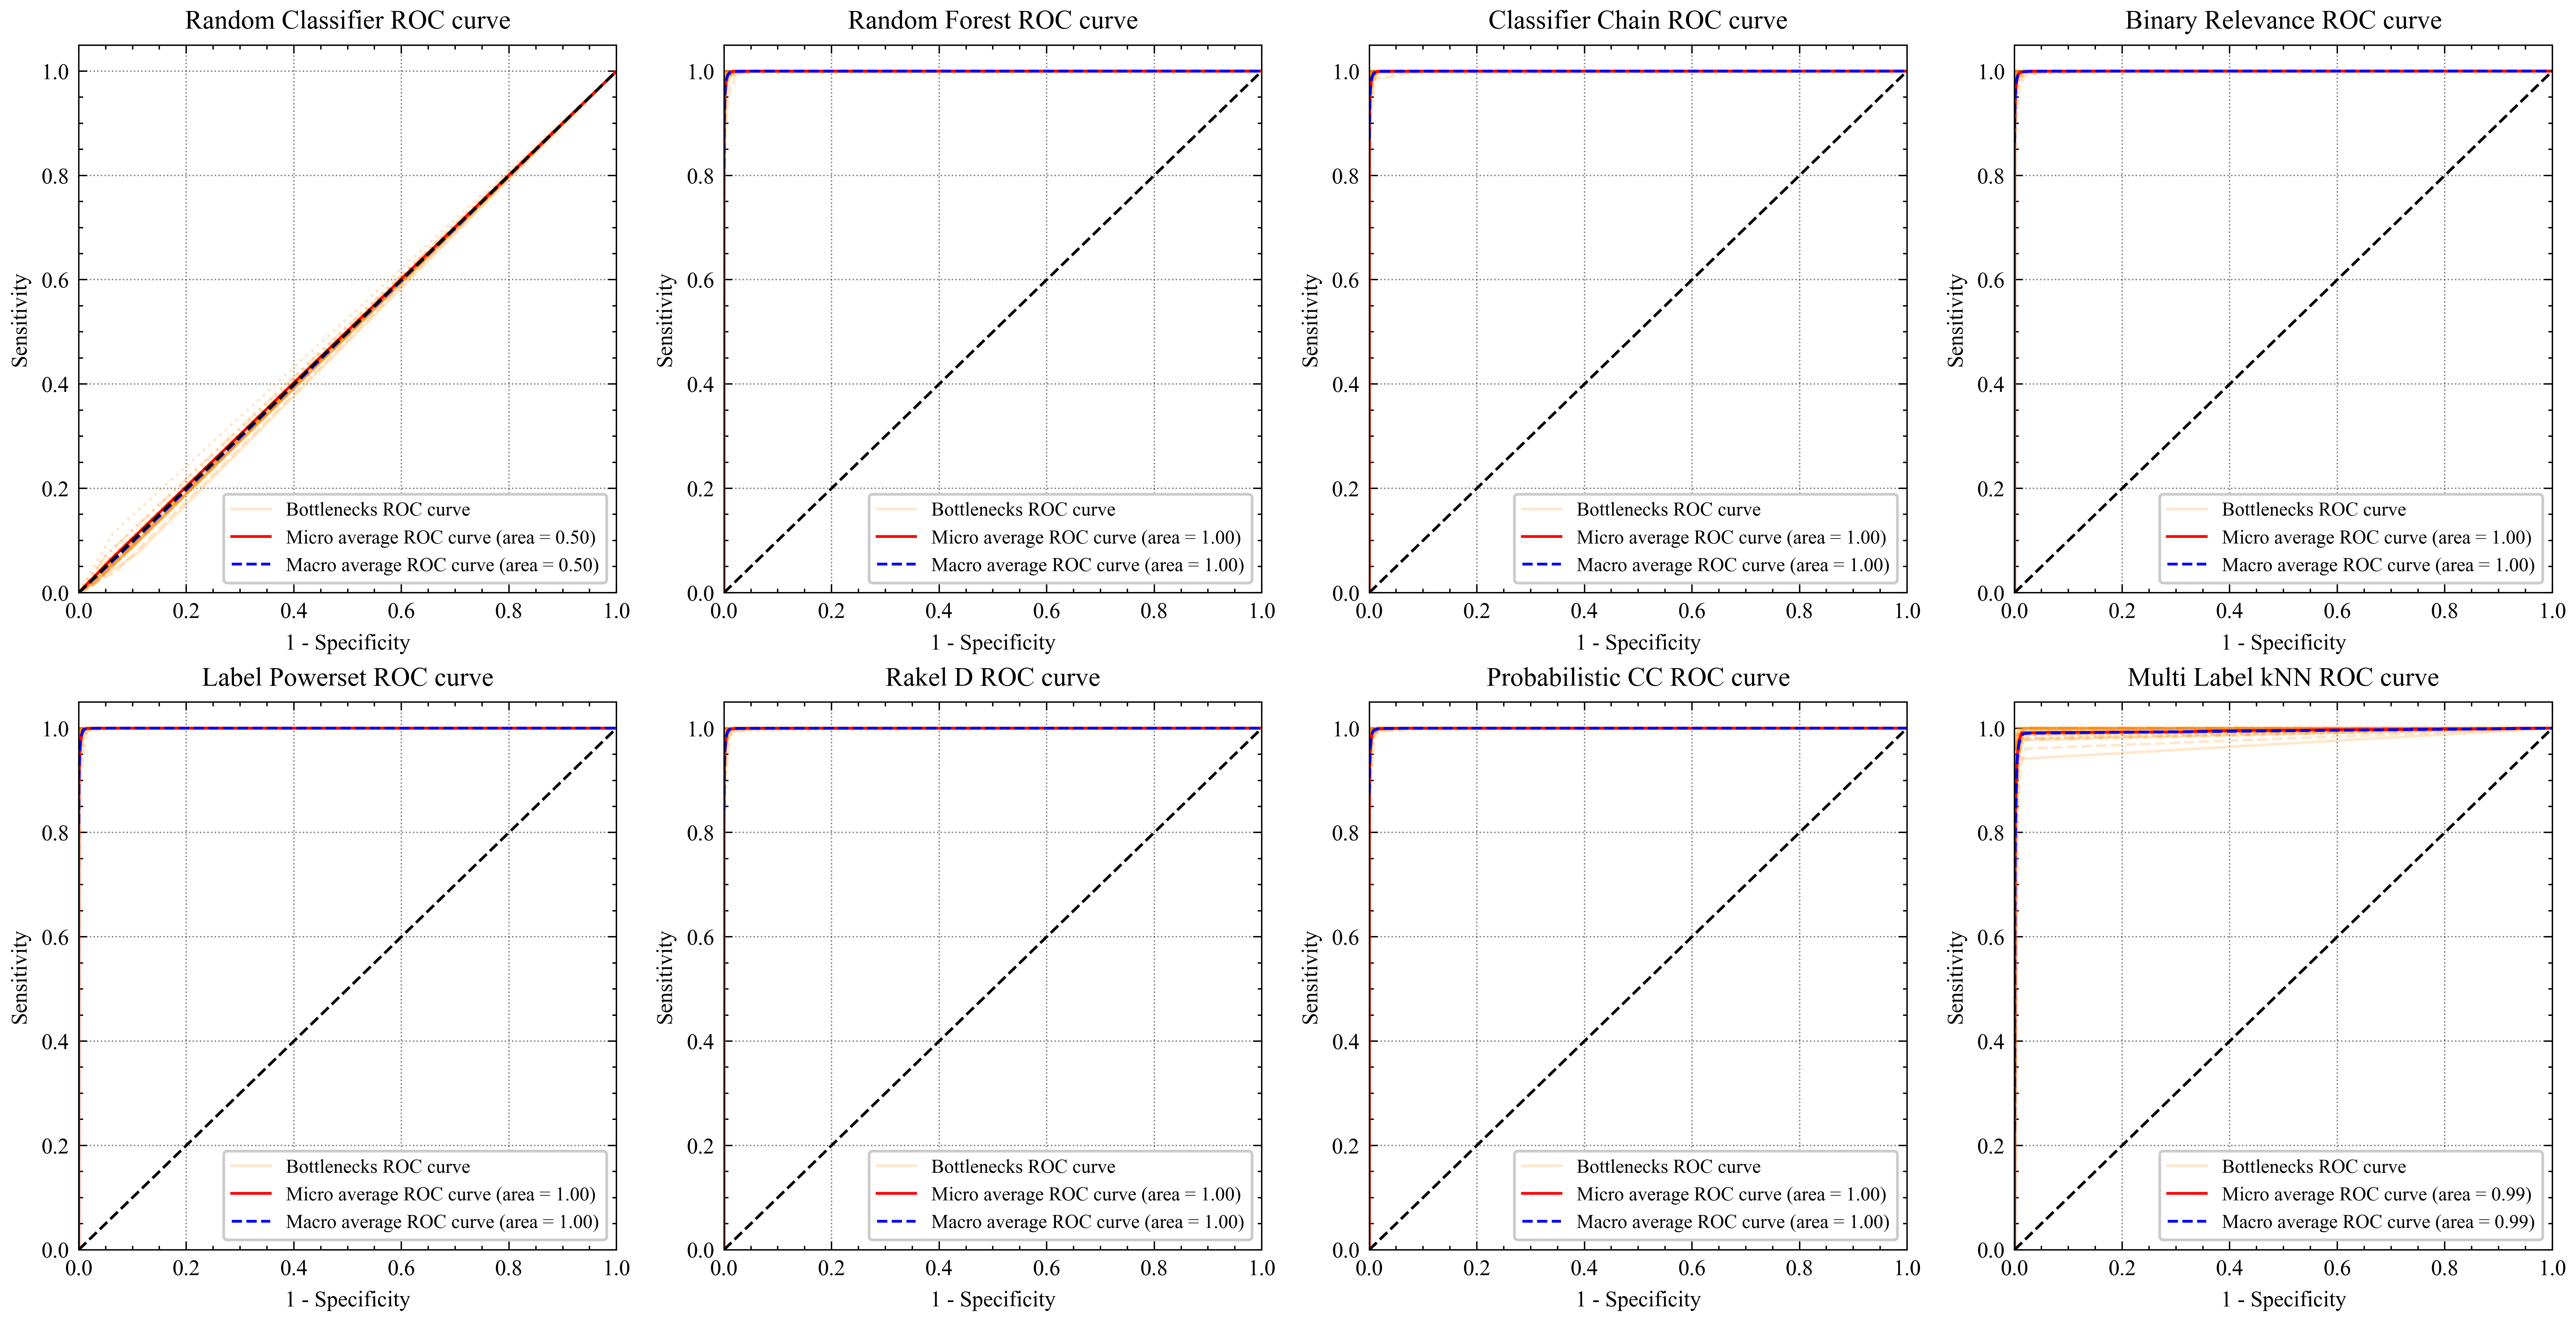

In [13]:
fig = train_and_plot(X_train, y_train)

In [ ]:
fig = plot_dor(results, y_test, bottleneck_names)

In [ ]:
df_c = compute_classification_score(results, y_test, many=True)
df_c

In [ ]:
df_r = compute_multilabel_ranking_metrics(results, y_test)
df_r

In [ ]:
#compute_measure_per_label(results, y_test, labels)

In [ ]:
fig = perf_viz(results, y_test)

In [ ]:
best={'Accuracy':df_c['Accuracy'].idxmax(),'Precision':df_c['Precision'].idxmax(),'Recall':df_c['Recall'].idxmax(),'F1':df_c['F1'].idxmax(),'Hamming loss':df_c['Hamming loss'].idxmin(),'Jaccard index':df_c['Jaccard index'].idxmax(),'Coverage error':df_r['Coverage error'].idxmin(), 'Label ranking average precision':df_r['Label ranking average precision'].idxmax(),'Label ranking loss':df_r['Label ranking loss'].idxmin()}
best={key: [value for value, check_key in best.items() if check_key==key] for key in best.values()}

In [ ]:
for k in best:
    print(k, ':', best[k])

In [ ]:
selection="Label Powerset"
y_pred = results[selection]
_ = plot_multi_confusion_matrix(y_pred,y_test, bottleneck_names, selection)

## Scenario 4 : Limited budget (1/4 total overhead) + Overhead increases by a factor of 0.5 from SRV --> GW111

## Scenario 3 : Limited budget (1/2 total overhead) + Overhead increases by a factor of 0.5 from SRV --> GW111

In [ ]:
scn_name='scn_3'
SRV_costs= 0.5 * np.ones(n_metric_SRV)
GW1_costs= 1.0 * np.ones(n_metric_GW1)
GW11_costs= 1.5 * np.ones(n_metric_GW11)
GW111_costs= 2.0 * np.ones(n_metric_GW111)          
overheads=np.concatenate([SRV_costs, GW1_costs, GW11_costs, GW111_costs])
overhead_budget=np.sum(overheads)//2
best_clf=classifiers[selection]#["Binary Relevance"]
osdms = OverheadSensitiveMetricSelection(best_clf, overheads=overheads, overhead_budget=overhead_budget, 
                                         scoring=SCORING, verbose=2, cv=CV, n_jobs=-1)
start=time.time()
osdms.fit(metrics.values, bottlenecks.values, custom_metric_names=metric_names)
print(5*'-'+'>','time:',(time.time()-start)//60+1,'minutes')
if save:
    dump(osdms, models_path + scn_name +'OSDMS.joblib')
print('best combination (Score: %.5f, numb : %d):\n%s' % (osdms.k_score_,len(osdms.k_metric_names_),
                                                           osdms.k_metric_names_))
fig, df = plot_osdm(osdms)
if save:
    df.to_csv(models_path + scn_name + '_metric_selection.csv', index=True)
    fig.savefig(fig_path + scn_name + '_metric_selection.pdf', bbox_inches='tight')

## Scenario 2 : Limited budget (1/4 total overhead) + Same overhead for all metrics

## Scenario 1 : Limited budget (1/2 total overhead) + Same overhead for all metrics

## Scenario 0 : Unlimited budget + Same overhead for all metrics